# Raspberry Turk Robotic Arm

## Introduction

The Raspberry Turk uses a robotic arm ([SCARA](https://en.wikipedia.org/wiki/SCARA)) to pick up and move chess pieces. The arm consists of two links, whose rotation is each controlled by a separate servo. This allows it to move freely in the X-Y direction while remaining rigid in the Z direction. There is a third servo that controls the vertical motion at the end of the arm.

![](assets/realarm.png)

In order to move pieces, the robot needs to be able to adjust the servos rotation $(s_1, s_2)$ to accurately move the arm to any given $x, y$ coordinate on the board.

$s_1, s_2 = g(x, y)$

**Our goal in this notebook is to create this function $g(x, y)$.**

## Working Backwards

We'll eventualy get to $g(x, y)$, but to get there we need to work backwards. To begin, let's first formalize what we know.

![](assets/slice1.png)

The arm consists of two links of length $l_i$. Since we know the lengths of the links, we can come up with an equation to determine $x, y$ given their angles $(\theta_i)$.

$$f_x(\theta_1, \theta_2) = x_{offset} + cos(\theta_1) \cdot l_1 + cos(\theta_1 + \theta_2) \cdot l_2$$
$$f_y(\theta_1, \theta_2) = y_{offset} + sin(\theta_1) \cdot l_1 + sin(\theta_1 + \theta_2) \cdot l_2$$

Now, in order to derive $\theta_i$ we need to learn more about the servo and how it's attached to the arm.

![](assets/dx_series_goal.png)
<center>[_Diagram from Robotis Dynamixel AX-12A support manual_](http://support.robotis.com/en/product/dynamixel/ax_series/dxl_ax_actuator.htm#Actuator_Address_1E)</center>

You can adjust the rotation of the servo by setting the goal position address in the RAM of the servo. The goal position address is a number between 0 and 1023 (10 bit value) that maps to a 0° to 300° rotation. This equates to an accuracy of 0.29° per unit change in value (not bad!).

![](assets/servo.jpg)

The servo is attached to a pinion gear which rotates a larger gear that the link of the arm is directly attached to. The pinion gear has 32 teeth and the larger gear has 76 teeth. This gives us a gear ratio of $\frac{76}{32}$ or $2.375 : 1$. From now on we'll refer to this gear ratio as $\phi$. Additionally, we must account of the rotational offset of the link when the servo goal position has a value of $0$. We'll call this rotational offset $\theta'_i$. Given this, we can how calculate $\theta_i$ given the goal position ($s_i$) of the servo.

$$\theta_i(s_i) = \theta'_i + \frac{1023-s_i}{1023}\cdot 300°\cdot \phi$$

Now, we have everything we need to convert any $s_1, s_2$ to an $x, y$.

$$f_x(s_1, s_2) = x_{offset} + \cos(\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1)\cdot l_1 + \cos((\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1) + (\frac{1023-s_2}{1023}\cdot 300°\cdot \phi + \theta'_2)) \cdot l_2 \\[10pt]$$
$$f_y(s_1, s_2) = y_{offset} + \sin(\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_{s_1})\cdot l_1 + \sin((\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1) + (\frac{1023-s_2}{1023}\cdot 300°\cdot \phi + \theta'_2)) \cdot l_2$$

However, both $f_x$ and $f_y$ are assuming ideal conditions. In reality there is error introduced by inaccuracies in measurements, and unaccounted for real world effects on the system.

## INSERT Image showing error

In order to achieve better accuracy in reality we need to better understand this error component and account for it.

$$f'_x(s_1, s_2) = f_x(s_1, s_2) + \epsilon_x(s_1, s_2)$$
$$f'_y(s_1, s_2) = f_y(s_1, s_2) + \epsilon_y(s_1, s_2)$$

$f'_x$ and $f'_y$ represent the actual real world $x, y$ given any $s_1, s_2$, where $\epsilon_x$ and $\epsilon_y$ is the respective error. In a more simple form:

$$f'(s) = f(s) + \epsilon(s)$$

To achieve a $f'(s)$ that is suffienct for our purposes we need to, as accurately as possible, model $\epsilon$.

In order to model $\epsilon$ we first need to collect a sample of data points. To do this I manually moved the arm to to 81 points and recorded the real $x, y$ and the respective $s_1, s_2$. Let's begin there.

In [34]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/arm_error.csv')

In [35]:
data.head()

,s1,s2,x,y
0,192,550,0.0,0.00
1,237,577,0.0,2.25
2,278,605,0.0,4.50
3,320,713,0.0,9.00
4,323,865,0.0,13.50


We need two new columns for $x$ and $y$ error. We can calculate this by first calulating the theoretical coordinate and then subtracting the observed coordinate.

In [36]:
dynamixel_range = 300.0
gear_ratio = 76.0 / 32.0
theta_prime_1 = np.pi/12.0
theta_prime_2 = np.pi/4.0
l_1 = 15.25
l_2 = 13.75
x_offset = 17.0
y_offset = -2.97

def f(s):
    theta_1 = ((1023.0-s[:,0])/1023.0) * np.deg2rad(dynamixel_range / gear_ratio) + theta_prime_1
    theta_2 = ((1023.0-s[:,1])/1023.0) * np.deg2rad(dynamixel_range / gear_ratio) + theta_prime_2
    x = x_offset + np.cos(theta_1) * l_1 + np.cos(theta_1 + theta_2) * l_2
    y = y_offset + np.sin(theta_1) * l_1 + np.sin(theta_1 + theta_2) * l_2
    return np.array([x, y]).T



In [37]:
theoretical_xy = f(data.values[:,0:2])
data.rename(columns = {'x': 'x_real', 'y': 'y_real'}, inplace=True)
data["x_theory"] = theoretical_xy[:,0]
data["y_theory"] = theoretical_xy[:,1]
data["x_error"] = data["x_real"] - data["x_theory"]
data["y_error"] = data["y_real"] - data["y_theory"]

In [38]:
data.head()

,s1,s2,x_real,y_real,x_theory,y_theory,x_error,y_error
0,192,550,0.0,0.00,-0.442540,1.520490,0.442540,-1.520490
1,237,577,0.0,2.25,-0.370674,3.853110,0.370674,-1.603110
2,278,605,0.0,4.50,-0.055753,6.109135,0.055753,-1.609135
3,320,713,0.0,9.00,0.184550,10.739774,-0.184550,-1.739774
4,323,865,0.0,13.50,0.638884,15.317258,-0.638884,-1.817258


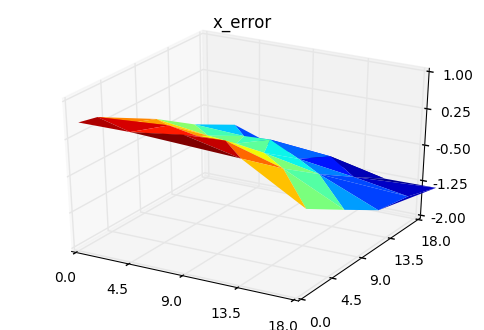

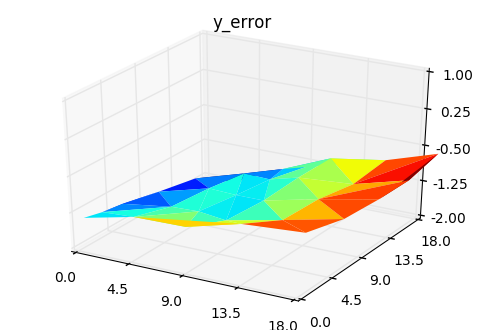

In [45]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

def plot_error(error, x=data.x_theory, y=data.y_theory):
    fig = plt.figure()
    axes = fig.gca(projection='3d')
    axes.plot_trisurf(x, y, error, cmap=cm.jet, linewidth=0.0)
    axes.set_xlim(0.0, 18.0)
    axes.set_ylim(0.0, 18.0)
    axes.set_zlim(-2.0, 1.0)

    axes.xaxis.set_major_locator(LinearLocator(5))
    axes.yaxis.set_major_locator(LinearLocator(5))
    axes.zaxis.set_major_locator(LinearLocator(5))
    axes.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    plt.title(error.name)
    plt.show()
    
plot_error(data.x_error)
plot_error(data.y_error)

In order to model error, we can use a polynomial regression.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X_train = data.values[:,0:2]
z = data.values[:,6:8]

poly = PolynomialFeatures(degree=20)
X_train = poly.fit_transform(X_train)

x_error_model = LinearRegression()
x_error_model.fit(X_train, z[:, 0])

y_error_model = LinearRegression()
y_error_model.fit(X_train, z[:, 1])

def predict_error(s):
    features = poly.fit_transform(s)
    return np.array([x_error_model.predict(features), y_error_model.predict(features)]).T

We can plot the `predict_error` function and compare them to the real error plots.

Using the `predict_error` function, let's get create the function we set out to create, $f'(s)$.

In [ ]:
def f_prime(s):
    return f(s) + predict_error(s)

Now that we have a working $f'(s)$, we can set out to accomplish our original goal, to create $g(x, y)$. $f'$ takes a $s_1, s_2$ and returns $x, y$. $g$ takes $x, y$ and returns $s_1, s_2$. In order to find $g$, we just need to invert $f'$! But it's not so simple. $f'$

In [ ]:
from itertools import product

srange = np.array(list(product(range(1024), range(1024))))
pts = f_prime(srange)

In [ ]:
from sklearn.neighbors import KDTree

tree = KDTree(pts, metric='euclidean')

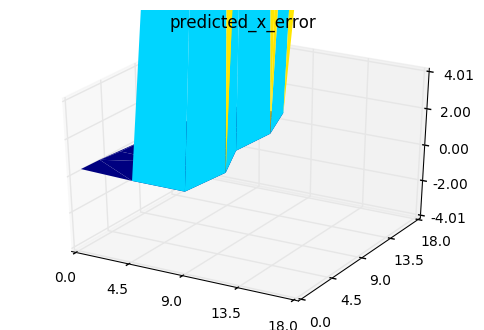

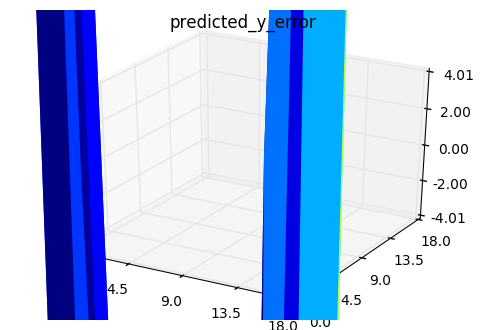

In [24]:
from itertools import product
srange = np.array(list(product(range(0,18,2.25), range(0,18,2.25))))

predicted_error = predict_error(data.values[:,0:2])

plot_error(pd.Series(data=srange[:,0], name='predicted_x_error'), x=)
plot_error(pd.Series(data=srange[:,1], name='predicted_y_error'))

In [ ]:
import os
import sys
import platform
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from raspberryturk.core import motion
import pickle


fn = "move.{}.kdtree".format(platform.machine())
path = os.path.join(os.path.dirname(os.path.abspath(motion.__file__)), fn)
with open(path, 'wb') as f:
    pickle.dump(tree, f)